In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install
  #!pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@master # for specific branch

import numpy as np         
import pandas as pd
import matplotlib.pyplot as plt
from equadratures import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Load the data

In [2]:
# Download and load the UCI aerofoil noise dataset (00291)
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat -O airfoil_self_noise.dat
data = pd.read_table('airfoil_self_noise.dat',names=["frequency","aoa","chord","vinf","delta","noise"])

--2020-04-13 14:09:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59984 (59K) [application/x-httpd-php]
Saving to: ‘airfoil_self_noise.dat’

airfoil_self_noise. 100%[===================>]  58.58K   173KB/s    in 0.3s    

2020-04-13 14:09:52 (173 KB/s) - ‘airfoil_self_noise.dat’ saved [59984/59984]



In [3]:
data

,frequency,aoa,chord,vinf,delta,noise
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [4]:
features = ['frequency','aoa','chord','vinf','delta']
target   = 'noise'
Xorig = data[features]
y = data[target]

In [5]:
def r2_score(y_true, y_pred):
    from sklearn.metrics import r2_score
    r2 = r2_score(y_true, y_pred)
    adj_r2 = (1 - (1 - r2) * ((y_true.shape[0] - 1) / 
                              (y_true.shape[0] - y_true.shape[1] - 1)))
    return adj_r2

## Exploring the data

Text(0, 0.5, "['noise']")

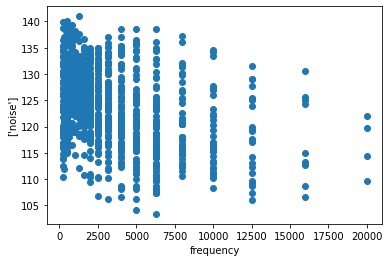

In [164]:
feature = features[0]
plt.plot(X_train[feature],y_train,'o')
plt.xlabel(feature)
plt.ylabel(target)

## Data cleaning

In [196]:
nu = 1.568e-5 
X = Xorig.copy()
X['Re'] = X['chord']*X['vinf']/nu
X=X.drop(columns=['chord','vinf'])
#X['aoa'] = np.abs(X['aoa'])
features = X.keys()

## Fitting some models!

In [354]:
global X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42)

In [432]:
def test_model(model,name):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)   
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train,y_pred_train)
    r2_test = r2_score(y_test,y_pred_test)

    fig, ax = plt.subplots()
    ax.set_title('$R^2$ train = %.3f, $R^2$ test = %.3f' %(r2_train,r2_test))
    fig.suptitle(name)
    ax.plot(y_train,y_pred_train,'C0o',ms=8,mec='k',label='Train')
    ax.plot(y_test, y_pred_test ,'C3o',ms=8,mec='k',label='Test',alpha=0.5)
    ax.plot([0,150],[0,150],'k--')
    ax.set_xlabel('True SPL (dB)')
    ax.set_ylabel('Predicted SPL (dB)')
    ax.set_xlim([100,140])
    ax.set_ylim([100,140])
    ax.set_aspect(1)
    ax.legend()
    plt.show()

### Linear regression

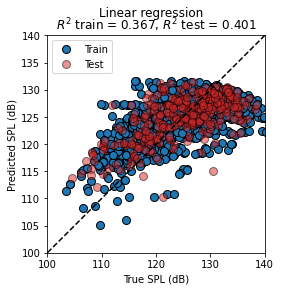

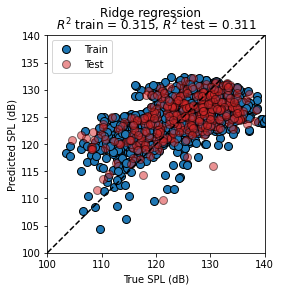

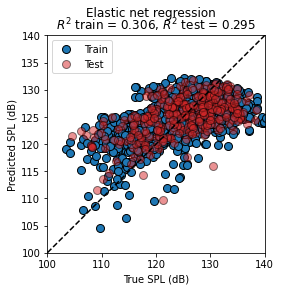

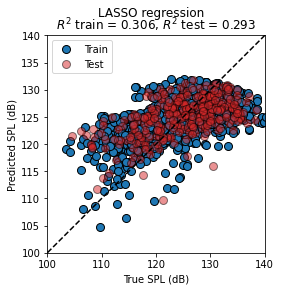

In [455]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet,Lars, Lasso,LassoLars
test_model(LinearRegression(),'Linear regression')
test_model(Ridge(),'Ridge regression')
test_model(ElasticNet(),'Elastic net regression')
#test_model(Lars(),'LARS regression')
test_model(Lasso(),'LASSO regression')
#test_model(LassoLars(),'LASSO LARS regression')

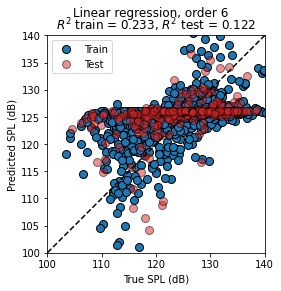

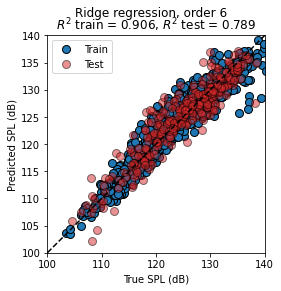

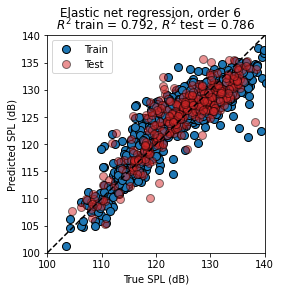

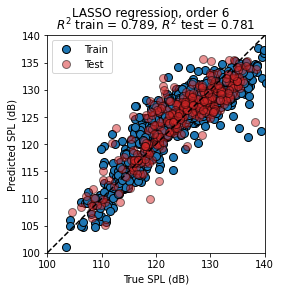

In [528]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
pipe = lambda model, deg: make_pipeline(PolynomialFeatures(deg), model)

deg = 6
test_model(pipe(LinearRegression(),deg),'Linear regression, order %d' %deg)
test_model(pipe(Ridge()           ,deg),'Ridge regression, order %d' %deg)
test_model(pipe(ElasticNet()      ,deg),'Elastic net regression, order %d' %deg)
#test_model(pipe(Lars()            ,deg),'LARS regression, order %d' %deg)
test_model(pipe(Lasso()           ,deg),'LASSO regression, order %d' %deg)
#test_model(pipe(LassoLars()       ,deg),'LASSO LARS regression, order %d' %deg)

### Decision tree

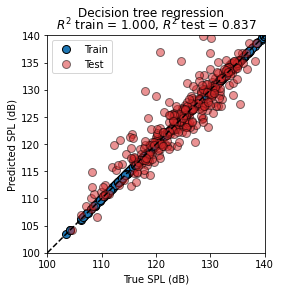

In [501]:
test_model(DecisionTreeRegressor(max_depth=None),'Decision tree regression')

### Random forest

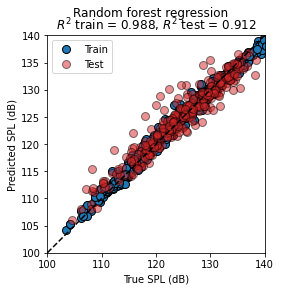

In [500]:
test_model(RandomForestRegressor(max_depth=None,n_estimators=100),'Random forest regression')

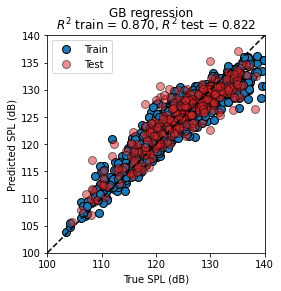

In [527]:
from sklearn.ensemble import GradientBoostingRegressor
test_model(GradientBoostingRegressor(),'GB regression')

### Orthogonal polynomials

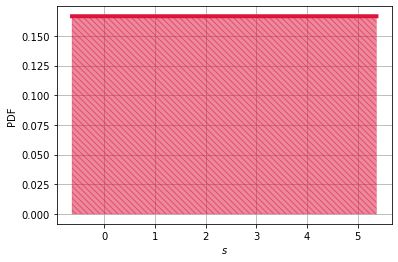

In [534]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler().fit(X_train)
#scaler = MinMaxScaler((-1,1)).fit(X_train)
X_train_temp = scaler.transform(X_train)
X_test_temp  = scaler.transform(X_test)

myparameters = [Parameter(distribution='uniform', lower=np.min(X_train_temp[f]), upper=np.max(X_train_temp.max()), order=3) for f in range(len(features))]
#myparameters = [Parameter(distribution='custom', data=X_train_temp[f], order=3) for f in range(len(features))]
mybasis = Basis('total-order')
#mybasis = Basis('tensor-grid')
#mybasis = Basis('euclidean-degree')
#mybasis = Basis('hyperbolic-basis',q=0.9)
#mybasis = Basis('sparse-grid', growth_rule='linear', level=2)
method = 'least-squares'
mypoly = Poly(parameters=myparameters, basis=mybasis, method=method, \
              sampling_args= {'mesh': 'user-defined', 'sample-points': X_train_temp, 'sample-outputs': y_train.to_numpy()})
mypoly.set_model()

s = myparameters[0]
s_values, pdf = s.get_pdf()
s_samples = s.get_samples(6000)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
plt.plot(s_values, pdf, '-', c='crimson', lw=4)
plt.xlabel('$s$')
plt.ylabel('PDF')
plt.fill_between(s_values,  pdf*0.0, pdf, color="crimson" , interpolate=True, hatch="\\\\\\\\", edgecolor="grey",  linewidth=0.5,alpha=0.5)
plt.grid()

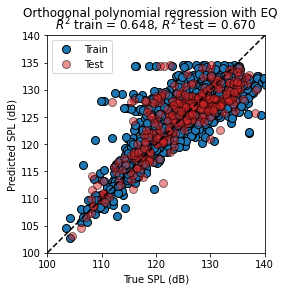

In [535]:
y_pred_train = mypoly.get_polyfit(X_train_temp)
y_pred_test  = mypoly.get_polyfit(X_test_temp)
r2_train = r2_score(y_train,y_pred_train)
r2_test = r2_score(y_test,y_pred_test)

fig, ax = plt.subplots()
ax.set_title('$R^2$ train = %.3f, $R^2$ test = %.3f' %(r2_train,r2_test))
fig.suptitle('Orthogonal polynomial regression with EQ')
ax.plot(y_train,y_pred_train,'C0o',ms=8,mec='k',label='Train')
ax.plot(y_test, y_pred_test ,'C3o',ms=8,mec='k',label='Test',alpha=0.5)
ax.plot([0,150],[0,150],'k--')
ax.set_xlabel('True SPL (dB)')
ax.set_ylabel('Predicted SPL (dB)')
ax.set_xlim([100,140])
ax.set_ylim([100,140])
ax.set_aspect(1)
ax.legend()
plt.show()

## Interpreting the models

## Conclusions